# Notebook that allows to see how to train the neural networks and how to obtain the optimal hyperparameters

In [1]:
from classes.Ann import Ann
from classes.DataLoader import DataLoader
from classes.DataLoader_batch import DataLoader_batch
from classes.Simulation import Simulation

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np

from utils.init_functions import random_normal
from utils.grid_search import grid_search
from utils.ann_keras import model_ts

c:\Users\Alexandre\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data loading and normalization (period 2000-2007)

In [2]:
index = "S&P500"
data = pd.read_csv("data/dataset.csv", index_col=0)
df_trv = data.rolling(5).std()
df_trv.index = pd.to_datetime(df_trv.index)
df_trv = df_trv.iloc[4:]
dfe = df_trv[index].dropna() 
mi = dfe.min()
ma = dfe.max()
dfe = (dfe - mi)/(ma-mi)
df = dfe["2000":"2007"]

### Differentiation of the different data sets of the paper

In [3]:
pivot_index_training_1 = round(df.shape[0] * 0.25)
pivot_index_training_2 = round(df.shape[0] * 0.75)

df_train_1 = df.iloc[:pivot_index_training_1]
df_train_2 = df.iloc[pivot_index_training_1:pivot_index_training_2]
df_validation = df.iloc[pivot_index_training_2:]

### Fitting of the Random Forest, Gradient Boosting and Machine Vector Support with 25% of the data

In [23]:
ite_train_1 = DataLoader(df=df_train_1, Y=df_train_1.values, window_size=30, batch_size=df_train_1.shape[0])
for batch in ite_train_1: # Only one batch there
    X_train_1,y_train_1 = batch

rf_rgs = RandomForestRegressor()  # RandomForestRegressor(max_features = 10, min_samples_split = 24)   
rf_rgs.fit(X_train_1,y_train_1)

sv_rgs = SVR(kernel='rbf')
sv_rgs.fit(X_train_1,y_train_1)

gb_rgs = GradientBoostingRegressor()  # GradientBoostingRegressor(learning_rate = 0.003, n_estimators=1479)
gb_rgs.fit(X_train_1,y_train_1)

GradientBoostingRegressor()

# TensorFlow

### Creation of the dataset including the forecasts of the 3 models

In [24]:
ite_train_2 = DataLoader(df=df_train_2, Y=df_train_2.values, window_size=30, batch_size=df_train_2.shape[0])
ite_test = DataLoader(df=df_validation, Y=df_validation.values, window_size=30, batch_size=df_validation.shape[0])

for batch in ite_train_2: # Only one batch there
    X_train_2,y_train_2 = batch

for batch in ite_test: # Only one batch there
    X_test,y_test = batch

df_train_ann = pd.DataFrame(X_train_2, index=df_train_2.index[30:])
df_train_ann["rf"] = rf_rgs.predict(X_train_2)
df_train_ann["sv"] = sv_rgs.predict(X_train_2)
df_train_ann["gb"] = gb_rgs.predict(X_train_2)

df_validation_ann = pd.DataFrame(X_test, index=df_validation.index[30:])
df_validation_ann["rf"] = rf_rgs.predict(X_test)
df_validation_ann["sv"] = sv_rgs.predict(X_test)
df_validation_ann["gb"] = gb_rgs.predict(X_test)

### Training of the neural network

In [13]:
model = model_ts(33)

history = model.fit(df_train_ann, 
          y_train_2,
          batch_size=len(X_train_2[0]), 
          epochs=10000,
          verbose=0,
          validation_data=(df_validation_ann.values,y_test), 
          shuffle=False,
         )

### Visualization

<AxesSubplot: title={'center': 'Loss across the time'}, xlabel='Epoch', ylabel='Loss'>

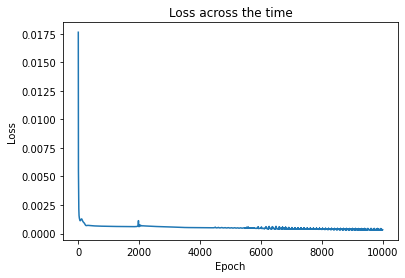

In [14]:
pd.DataFrame(history.history["loss"], columns=["test_loss"]).plot(title='Loss across the time', xlabel="Epoch", ylabel="Loss", legend=False)

27/27 [==============================] - 0s 2ms/step


<AxesSubplot: title={'center': 'Prediction through the training set, RMSE : 0.01835'}, xlabel='Date', ylabel='Scaled volatility'>

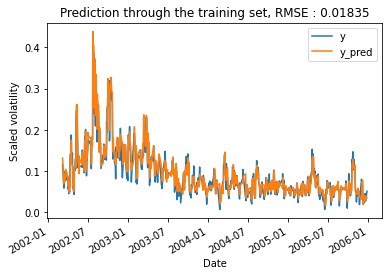

In [15]:
df_train = pd.DataFrame(y_train_2, columns=["y"], index=df_train_ann.index)
df_train["y_pred"] = model.predict(df_train_ann)
df_train.plot(
    title="Prediction through the training set, RMSE : {:.5f}".format(mean_squared_error(df_train["y"], df_train["y_pred"], squared=False)),
    ylabel="Scaled volatility")

13/13 [==============================] - 0s 2ms/step


<AxesSubplot: title={'center': 'Prediction through the test set, RMSE : 0.02580'}, xlabel='Date', ylabel='Scaled volatility'>

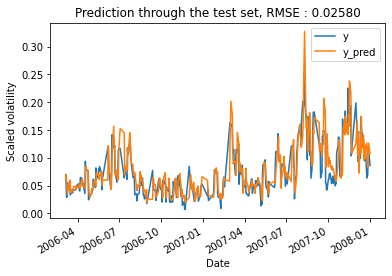

In [16]:
df_train = pd.DataFrame(y_test, columns=["y"], index=df_validation_ann.index)
df_train["y_pred"] = model.predict(df_validation_ann)
df_train.plot(
    title="Prediction through the validation set, RMSE : {:.5f}".format(mean_squared_error(df_train["y"], df_train["y_pred"], squared=False)),
    ylabel="Scaled volatility")

7/7 [==============================] - 0s 3ms/step


<AxesSubplot: title={'center': 'Prediction through the next year, RMSE : 0.13594'}, xlabel='Date', ylabel='Scaled volatility'>

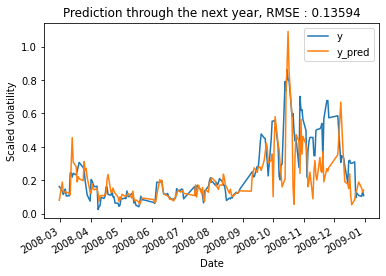

In [18]:
df_comparaison = dfe["2008"]
ite_comp = DataLoader(df=df_comparaison, Y=df_comparaison.values, window_size=30, batch_size=df_comparaison.shape[0])
for batch in ite_comp: # Only one batch there
    X_comp,y_comp = batch
    
df_rep = pd.DataFrame(X_comp, index=df_comparaison.index[30:])
df_rep["rf"] = rf_rgs.predict(X_comp)
df_rep["sv"] = sv_rgs.predict(X_comp)
df_rep["gb"] = gb_rgs.predict(X_comp)

ite_comp_ann = DataLoader_batch(tab=df_rep.values, Y=y_comp, batch_size=len(df_rep.values))
for batch in ite_comp_ann: # Only one batch there
    X,y = batch

df_train = pd.DataFrame(y, columns=["y"], index = df_rep.index)
df_train["y_pred"] = model.predict(df_rep)
df_train.plot(
    title="Prediction through the next year, RMSE : {:.5f}".format(mean_squared_error(df_train["y"], df_train["y_pred"], squared=False)),
    ylabel="Scaled volatility")

# Torch (handmade)

### Creation of the dataset including the forecasts of the 3 models

In [21]:
df_ann = df.iloc[pivot_index_training_1:]
ite = DataLoader(df=df_ann, Y=df_ann.values, window_size=30, batch_size=df_ann.shape[0])

for batch in ite: # Only one batch there
    X,y = batch

df_train_ann = pd.DataFrame(X, index=df_ann.index[30:])
df_train_ann["rf"] = rf_rgs.predict(X)
df_train_ann["sv"] = sv_rgs.predict(X)
df_train_ann["gb"] = gb_rgs.predict(X)

kwargs = dict(
    period = "2008",
    learning_rate = 1e-3,
    batch_size = df_train_ann.shape[0],
    num_epochs = 10000, 
    window_size = 30,
    weight_decay = 0,
    #l2_lambda = 0.01,
    tab = df_train_ann.values,
    y = y,
)

### Creation of the model, initialization of weights, loading of dataloaders and training

In [22]:
sim = Simulation(**kwargs)
sim.Ann.init_weights(random_normal)
sim.make_dataloaders(pivot_index=pivot_index_training_2-pivot_index_training_1)
sim.train(verbose=1)

Train loss: 0.0383 | Test loss: 0.0697: 100%|██████████| 10000/10000 [01:07<00:00, 147.83it/s]


### Visualization

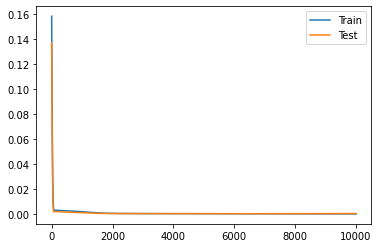

In [25]:
sim.plot_loss()

<AxesSubplot: title={'center': 'Prediction through the train set, RMSE : 0.01959'}, ylabel='Scaled volatility'>

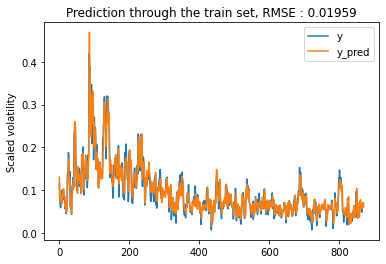

In [26]:
for batch in sim.dataloaders["train"]():
    x,y = batch

df_train = pd.DataFrame(y.numpy(), columns=["y"])
df_train["y_pred"] = sim.Ann(x).detach().numpy()
df_train.plot(
    title="Prediction through the train set, RMSE : {:.5f}".format(mean_squared_error(df_train["y"], df_train["y_pred"], squared=False)),
    ylabel="Scaled volatility")

<AxesSubplot: title={'center': 'Prediction through the validation set, RMSE : 0.02640'}, ylabel='Scaled volatility'>

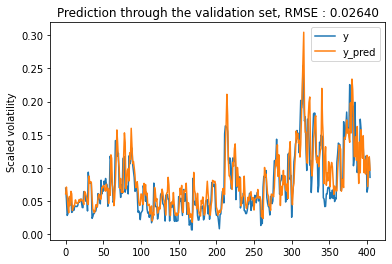

In [27]:
for batch in sim.dataloaders["test"]():
    x,y = batch

df_train = pd.DataFrame(y, columns=["y"])
df_train["y_pred"] = sim.Ann(x).detach().numpy()
df_train.plot(
    title="Prediction through the validation set, RMSE : {:.5f}".format(mean_squared_error(df_train["y"], df_train["y_pred"], squared=False)),
    ylabel="Scaled volatility")

<AxesSubplot: title={'center': 'Prediction through the next year, RMSE : 0.10745'}, xlabel='Date', ylabel='Scaled volatility'>

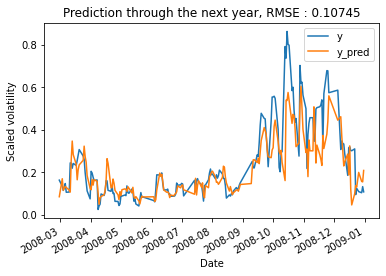

In [28]:
df_comparaison = dfe["2008"]
ite_comp = DataLoader(df=df_comparaison, Y=df_comparaison.values, window_size=30, batch_size=df_comparaison.shape[0])
for batch in ite_comp: # Only one batch there
    X_comp,y_comp = batch
    
df_rep = pd.DataFrame(X_comp, index=df_comparaison.index[30:])
df_rep["rf"] = rf_rgs.predict(X_comp)
df_rep["sv"] = sv_rgs.predict(X_comp)
df_rep["gb"] = gb_rgs.predict(X_comp)

ite_comp_ann = DataLoader_batch(tab=df_rep.values, Y=y_comp, batch_size=len(df_rep.values))
for batch in ite_comp_ann: # Only one batch there
    X,y = batch

df_train = pd.DataFrame(y, columns=["y"], index = df_rep.index)
df_train["y_pred"] = sim.Ann(X).detach().numpy()
df_train.plot(
    title="Prediction through the next year, RMSE : {:.5f}".format(mean_squared_error(df_train["y"], df_train["y_pred"], squared=False)),
    ylabel="Scaled volatility")

# Featuning hyperparameters on the last 25% and save the models
(require a lot of time of processing)

In [2]:
from classes.Ann import Ann
from classes.DataLoader import DataLoader
from classes.DataLoader_batch import DataLoader_batch
from classes.Simulation import Simulation

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

import pandas as pd
import numpy as np

from utils.init_functions import random_normal
from utils.grid_search import grid_search
from utils.ann_keras import model_ts


index = "S&P500"
data = pd.read_csv("data/dataset.csv", index_col=0)
df_trv = data.rolling(5).std()
df_trv.index = pd.to_datetime(df_trv.index)
df_trv = df_trv.iloc[4:]
dfe = df_trv[index].dropna() 
mi = dfe.min()
ma = dfe.max()
dfe = (dfe - mi)/(ma-mi)

periods = {
    "2000-2007":"2008",
    "2001-2008":"2009",
    "2002-2009":"2010",
    "2009-2016":"2017",
    "2010-2017":"2018",
}

best_params = {}

for period in periods:

    df = dfe[period[:4]:period[5:]]

    pivot_index_training_1 = round(df.shape[0] * 0.25)
    pivot_index_training_2 = round(df.shape[0] * 0.75)

    df_train_1 = df.iloc[:pivot_index_training_1]
    df_ann = df.iloc[pivot_index_training_1:]

    ite_train_1 = DataLoader(df=df_train_1, Y=df_train_1.values, window_size=30, batch_size=df_train_1.shape[0])
    for batch in ite_train_1: # Only one batch there
        X_train_1,y_train_1 = batch

    rf_rgs = RandomForestRegressor()  # RandomForestRegressor(max_features = 10, min_samples_split = 24)   
    rf_rgs.fit(X_train_1,y_train_1)

    sv_rgs = SVR(kernel='rbf')
    sv_rgs.fit(X_train_1,y_train_1)

    gb_rgs = GradientBoostingRegressor()  # GradientBoostingRegressor(learning_rate = 0.003, n_estimators=1479)
    gb_rgs.fit(X_train_1,y_train_1)

    ite = DataLoader(df=df_ann, Y=df_ann.values, window_size=30, batch_size=df_ann.shape[0])
    for batch in ite: # Only one batch there
        X,y = batch

    df_train_ann = pd.DataFrame(X, index=df_ann.index[30:])
    df_train_ann["rf"] = rf_rgs.predict(X)
    df_train_ann["sv"] = sv_rgs.predict(X)
    df_train_ann["gb"] = gb_rgs.predict(X)

    kwargs = dict(
        period = period,
        batch_size = df_train_ann.shape[0],
        num_epochs = 10000, 
        window_size = 30,
        weight_decay = 0,
        tab = df_train_ann.values,
        y = y,
    )

    best_params[period] = grid_search(
        learning_rate = np.linspace(0.0001,0.01,50),
        phi = [0, 0.01, 0.02],
        pivot=pivot_index_training_2-pivot_index_training_1,
        **kwargs
    )


Train loss: 0.0667 | Test loss: 0.0667: 100%|██████████| 10000/10000 [01:35<00:00, 104.47it/s]
Train loss: 0.3626 | Test loss: 0.2391: 100%|██████████| 10000/10000 [01:11<00:00, 140.20it/s]
Train loss: 0.3651 | Test loss: 0.2406: 100%|██████████| 10000/10000 [01:19<00:00, 126.25it/s]
Train loss: 0.0517 | Test loss: 0.0557: 100%|██████████| 10000/10000 [01:27<00:00, 114.76it/s]
Train loss: 0.3626 | Test loss: 0.2391: 100%|██████████| 10000/10000 [01:40<00:00, 99.85it/s]
Train loss: 0.3651 | Test loss: 0.2406: 100%|██████████| 10000/10000 [01:23<00:00, 119.28it/s]
Train loss: 0.0510 | Test loss: 0.0559: 100%|██████████| 10000/10000 [01:18<00:00, 127.02it/s]
Train loss: 0.3626 | Test loss: 0.2391: 100%|██████████| 10000/10000 [01:18<00:00, 127.23it/s]
Train loss: 0.3651 | Test loss: 0.2406: 100%|██████████| 10000/10000 [01:19<00:00, 126.15it/s]
Train loss: 0.0407 | Test loss: 0.0602: 100%|██████████| 10000/10000 [01:19<00:00, 126.01it/s]
Train loss: 0.3626 | Test loss: 0.2382: 100%|██████

KeyboardInterrupt: 

In [3]:
best_params

{'2000-2007': (0.0003020408163265306, 0)}